In [1]:
import pandas as pd
import vectorbtpro as vbt
import numpy as np
import datetime

Load in data

In [2]:
start_date_panel = '1996-04-30'
end_date_panel = '2023-02-28'

data = pd.read_excel('fx_beer_data.xlsx', engine='openpyxl',
                     sheet_name=['fx', 'tot', 'gfc', 'yield', 'cpi', 'prod'])

fx_data = data['fx'].set_index('date')
fx_data = fx_data.resample('M').last()

# transform all pairs to format base_fx/quote_fx with quote_fx always being usd as reference currency
fx_data['cadusd'] = 1 / fx_data.usdcad
fx_data['jpyusd'] = 1 / fx_data.usdjpy
fx_data['sekusd'] = 1 / fx_data.usdsek
fx_data['nokusd'] = 1 / fx_data.usdnok
fx_data['chfusd'] = 1 / fx_data.usdchf
fx_data['plnusd'] = 1 / fx_data.usdpln
fx_data['hufusd'] = 1 / fx_data.usdhuf
fx_data['czkusd'] = 1 / fx_data.usdczk

# list of tickers needed in final df

g12_tickers_conv = ['eurusd', 'usdcad', 'usdjpy', 'gbpusd', 'usdsek', 'usdnok', 'usdchf', 'audusd',
                    'nzdusd', 'usdpln', 'usdhuf', 'usdczk']
g12_tickers = ['eurusd', 'cadusd', 'jpyusd', 'gbpusd', 'sekusd', 'nokusd', 'chfusd', 'audusd', 'nzdusd',
               'plnusd', 'hufusd', 'czkusd']
g9_tickers = ['eurusd', 'cadusd', 'jpyusd', 'gbpusd', 'sekusd', 'nokusd', 'chfusd', 'audusd', 'nzdusd']
cee3_tickers = ['plnusd', 'hufusd', 'czkusd']

# final df for fx prices in log format and correct time_series format
fx = fx_data[g12_tickers]['1996-04-30':]
fx.shape

(323, 12)

In [3]:
for curr in fx.columns:
    pd.DataFrame({'open': fx[curr],
                  'high': fx[curr],
                  'low': fx[curr],
                  'close': fx[curr]}).to_csv(f'{curr}.csv')
import glob
dfs = []
for f in [x for x in glob.glob('*.csv') if '_signal' in x]:
    df = pd.read_csv(f, parse_dates=True, index_col=0)
    df = df[['dev_z']]
    df.columns = [f'{f.split("/")[-1].split("_")[0]}' for x in df.columns]
    dfs.append(df)
z_scores = pd.concat(dfs, axis=1)

In [5]:
z_scores['01-01-2006':]

,eurusd,hufusd,chfusd,cadusd,nzdusd,sekusd,audusd,gbpusd,plnusd,czkusd,nokusd,jpyusd
date,,,,,,,,,,,,
2006-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-28,-0.093640,NaN,-1.097357,0.624752,0.061901,-0.371343,0.047415,-0.678362,NaN,NaN,-1.168317,-1.756907
2006-03-31,0.255208,NaN,-0.937693,0.427900,-0.399846,-0.176252,-0.154751,-0.594290,NaN,NaN,-0.608772,-2.226562
2006-04-30,0.590377,NaN,-0.440546,1.081873,-0.126816,0.342493,0.258013,0.004034,NaN,NaN,-0.240476,-1.577333
2006-05-31,0.653462,NaN,-0.327694,1.103423,-0.248755,0.405831,0.018313,0.201672,NaN,NaN,-0.284143,-1.425527
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-31,-0.997161,-0.733672,-0.390562,-0.800811,-1.881706,-1.671877,-1.645073,-1.150521,-0.186042,1.954393,-2.266860,-0.100538
2022-11-30,-0.824813,-0.682475,0.024868,-0.616459,-1.370387,-1.416937,-0.962946,-0.835473,0.120847,1.413650,-1.893025,-0.564498
2022-12-31,-0.592620,0.792906,0.293637,-0.797074,-1.147898,-1.379613,-1.207259,-0.829543,0.814331,2.509984,-1.753892,0.111916


In [6]:
import vectorbtpro as vbt
import glob

data = vbt.CSVData.fetch(
    paths=[x for x in glob.glob('*csv') if "_signal" not in x],
)

wrapper = data.get_symbol_wrapper(freq="M")
close_data = data.get("close").ffill()

# NOTE the columns of data and z_signals are not the same: readjust:
z_scores = z_scores[close_data.columns]

  0%|          | 0/12 [00:00<?, ?it/s]

### Strategies per individual currency:
- Strategy 1: long if z_score < z_threshold and short vice versa (short followed by long means closing out and reversing)
- Strategy 2: long if z_score < z_threshold and hold until z_score raises with z_offset (and vice versa)

In [186]:

def beer_strat(close, signal, z_threshold=1, holding_months=12):
     
    long_entry = (signal<-z_threshold).astype(int)
    short_entry = (signal>z_threshold).astype(int)
    
    #offset the long_entries with <holding_months>
    long_exit = np.zeros_like(long_entry)
    idx = np.argwhere(signal>=0)
    valid_idx = idx[(idx< long_exit.shape).all(1)]
    long_exit[tuple(valid_idx.T)] = 1
    
    short_exit = np.zeros_like(long_entry)
    idx = np.argwhere(signal<=0)
    valid_idx = idx[(idx< long_exit.shape).all(1)]
    short_exit[tuple(valid_idx.T)] = 1
    
    # long_exit = np.zeros_like(long_entry)
    # idx = np.argwhere(signal<-z_threshold)+[holding_months,0]
    # valid_idx = idx[(idx< long_exit.shape).all(1)]
    # long_exit[tuple(valid_idx.T)] = 1
    
    # short_exit = np.zeros_like(long_entry)
    # idx = np.argwhere(signal>z_threshold)+[holding_months,0]
    # valid_idx = idx[(idx< long_exit.shape).all(1)]
    # short_exit[tuple(valid_idx.T)] = 1
    
    return long_entry, short_entry, long_exit, short_exit

my_indicator2 = vbt.IndicatorFactory(
	class_name="beer_strat",
	short_name="bes",
	input_names=["close", "signal"],
	param_names=["z_threshold"],
	output_names=['long_entry', 'short_entry', 'long_exit', 'short_exit']
	).with_apply_func(
        beer_strat,
        takes_1d=False,
        z_threshold=1,
	)
 
strat2 = my_indicator2.run(close=data.get("close").ffill(),
                           signal=z_scores.values,
                           z_threshold = np.arange(3,step=0.5),
                           param_product=True
)

pf1 = vbt.Portfolio.from_signals(
    close=data.get('close')[:'2013'], 
    entries=strat2.long_entry.astype(bool), 
    short_entries=strat2.short_entry.astype(bool),
    exits=strat2.long_exit.astype(bool),
    short_exits=strat2.short_exit.astype(bool), 
    fees=0.0,
    freq='D',
)

pf2 = vbt.Portfolio.from_signals(
    close=data.get('close')['2013':], 
    entries=strat2.long_entry.astype(bool), 
    short_entries=strat2.short_entry.astype(bool),
    exits=strat2.long_exit.astype(bool),
    short_exits=strat2.short_exit.astype(bool), 
    fees=0.0,
    freq='D',
)

<Axes: xlabel='bes_z_threshold', ylabel='symbol'>

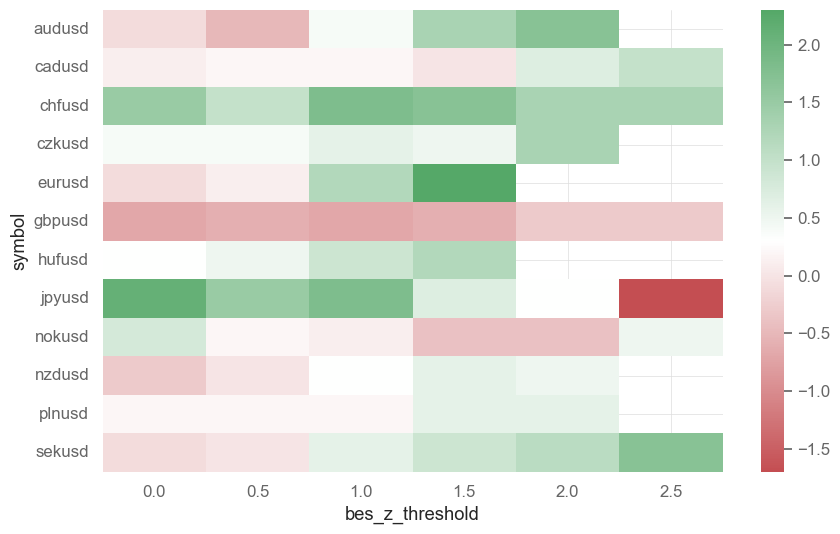

In [185]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 

df = pf1.sharpe_ratio.reset_index().groupby(['bes_z_threshold', 'symbol'])['sharpe_ratio'].aggregate('first').unstack()
df= round(df, 1)
df.index = np.round(df.index, 2)
sns.heatmap(df.T, cmap=cmap, annot=False)

<Axes: xlabel='bes_z_threshold', ylabel='symbol'>

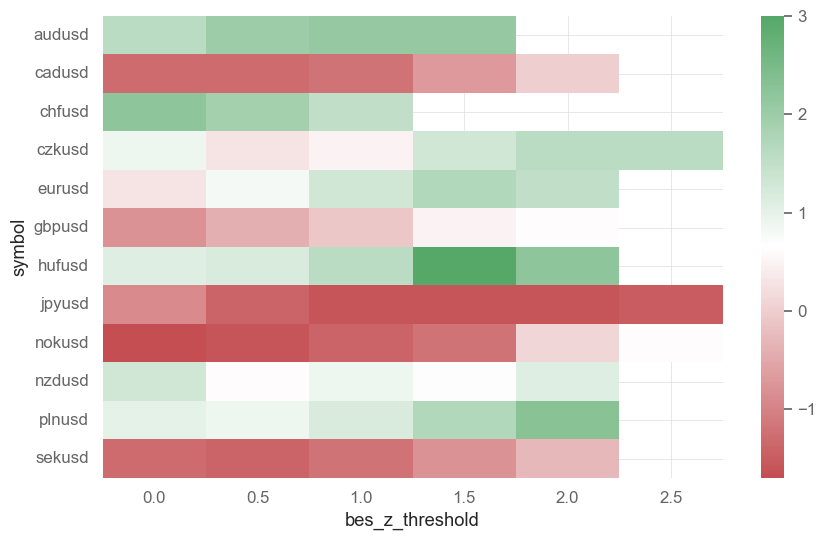

In [187]:
df = pf2.sharpe_ratio.reset_index().groupby(['bes_z_threshold', 'symbol'])['sharpe_ratio'].aggregate('first').unstack()
df= round(df, 1)
df.index = np.round(df.index, 2)
sns.heatmap(df.T, cmap=cmap, annot=False)

In [16]:

sns.heatmap(pf1.sharpe_ratio.reset_index())

ValueError: could not convert string to float: 'nokusd'

In [125]:
pf1.sharpe_ratio.vbt.heatmap(
    x_level='bes_z_threshold', 
    y_level='symbol',
).show()

/Users/tdrxy/opt/anaconda3/envs/vectorbtenv/lib/python3.10/site-packages/jupyter_client/session.py:719: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



In [101]:
pf2.sharpe_ratio.vbt.heatmap(
    x_level='bes_z_threshold', 
    y_level='symbol',
).show()

/Users/tdrxy/opt/anaconda3/envs/vectorbtenv/lib/python3.10/site-packages/jupyter_client/session.py:719: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



In [64]:
pf1[2]['nokusd'].plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'mode': 'lines',
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '89a950c4-92b7-4a8d-ae9a-b011f09000a1',
              'x': array([datetime.datetime(1996, 4, 30, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(1996, 5, 31, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(1996, 6, 30, 0, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2022, 12, 31, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 1, 31, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 2, 28, 0, 0, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'xaxis': 'x',
              'y': array([0.15212596, 0.15366176, 0.15374208, ..., 0.10200126,

<AxesSubplot: xlabel='date'>

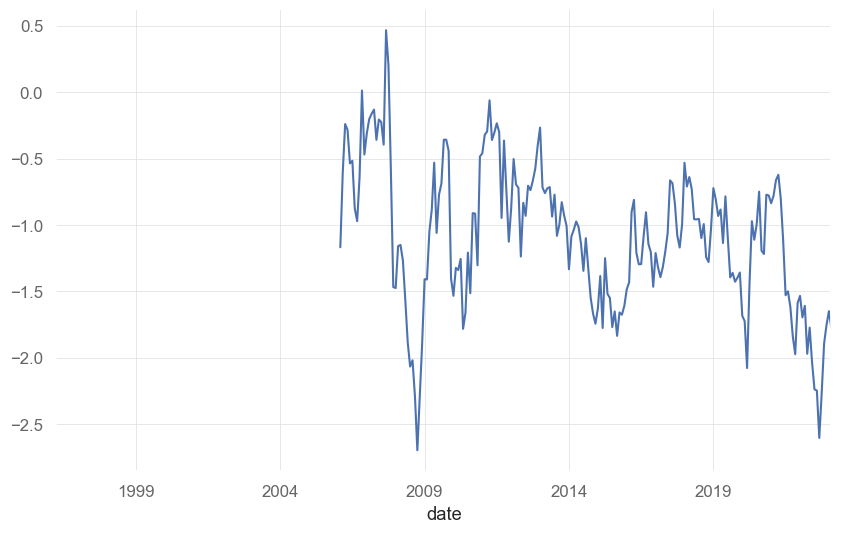

In [65]:
z_scores['nokusd'].plot()

In [19]:
pf.sharpe_ratio

NameError: name 'pf' is not defined

In [32]:
# https://vectorbt.pro/pvt_d904e513/tutorials/portfolio-optimization/#simulation
# def beer_strat(close, signal, z_threshold=1):
#     # 
#     long = (signal<-z_threshold).astype(int)
#     short = -(signal>z_threshold).astype(int)
#     signal = long+short
    
#     #weights = signal/np.abs(signal).sum(axis=1)[:,None]
#     return signal

# my_indicator1 = vbt.IndicatorFactory(
# 	class_name="beer_strat",
# 	short_name="bes",
# 	input_names=["close", "signal"],
# 	param_names=["z_threshold"],
# 	output_names=["entries"]
# 	).with_apply_func(
#         beer_strat,
#         takes_1d=False,
#         z_threshold=1
# 	)
 
# strat1_results = my_indicator1.run(close=data.get("close").ffill(),
#                            signal=z_scores.values,
#                            z_threshold=[0, 0.5, 1, 1.5, 2, 2.5, 3],
#                            param_product=True
# )

# longs1 = strat1_results.entries == 1
# shorts1 = strat1_results.entries == -1

# pf1 = vbt.Portfolio.from_signals(
#     close=data.get('close'), 
#     entries=longs1, 
#     exits=shorts1, 
#     fees=0.0,
#     freq='D'
# )


def beer_strat2(close, signal, z_threshold=1, holding_months=1):
    # strat 2
    long_entry = (signal<-z_threshold).astype(int)
    short_entry = (signal>z_threshold).astype(int)
    
    # offset the long_entries with <holding_months>
    long_exit = np.zeros_like(long_entry)
    idx = np.argwhere(signal<-z_threshold)+[holding_months,0]
    valid_idx = idx[(idx< long_exit.shape).all(1)]
    long_exit[tuple(valid_idx.T)] = 1
    
    short_exit = np.zeros_like(long_entry)
    idx = np.argwhere(signal>z_threshold)+[holding_months,0]
    valid_idx = idx[(idx< long_exit.shape).all(1)]
    short_exit[tuple(valid_idx.T)] = 1
    
    return long_entry, short_entry, long_exit, short_exit

my_indicator2 = vbt.IndicatorFactory(
	class_name="beer_strat2",
	short_name="bes2",
	input_names=["close", "signal"],
	param_names=["z_threshold", "holding_months"],
	output_names=['long_entry', 'short_entry', 'long_exit', 'short_exit']
	).with_apply_func(
        beer_strat2,
        takes_1d=False,
        z_threshold=1,
        holding_months=1
	)
 
strat2 = my_indicator2.run(close=data.get("close").ffill(),
                           signal=z_scores.values,
                           z_threshold = np.arange(3,step=0.1),
                           holding_months = np.arange(48),
                           param_product=True
)

pf2 = vbt.Portfolio.from_signals(
    close=data.get('close'), 
    entries=strat2.long_entry.astype(bool), 
    short_entries=strat2.short_entry.astype(bool),
    exits=strat2.long_exit.astype(bool),
    short_exits=strat2.short_exit.astype(bool), 
    fees=0.0,
    freq='D'
)

pf2.sharpe_ratio.sort_values(ascending=False)


bes2_z_threshold  bes2_holding_months  symbol
1.5               4                    hufusd    3.735508
0.9               31                   chfusd    3.428678
1.0               34                   chfusd    3.334109
0.9               33                   chfusd    3.313692
                  34                   chfusd    3.311030
                                                   ...   
2.9               47                   chfusd         NaN
                                       plnusd         NaN
                                       nzdusd         NaN
                                       audusd         NaN
                                       sekusd         NaN
Name: sharpe_ratio, Length: 17280, dtype: float64

In [33]:
pf2.sharpe_ratio.vbt.heatmap(
    x_level='bes2_z_threshold', 
    y_level='bes2_holding_months',
    slider_level='symbol'
).show()

/Users/tdrxy/opt/anaconda3/envs/vectorbtenv/lib/python3.10/site-packages/jupyter_client/session.py:719: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/Users/tdrxy/opt/anaconda3/envs/vectorbtenv/lib/python3.10/site-packages/jupyter_client/session.py:719: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/Users/tdrxy/opt/anaconda3/envs/vectorbtenv/lib/python3.10/site-packages/jupyter_client/session.py:719: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/Users/tdrxy/opt/anaconda3/envs/vectorbtenv/lib/python3.10/site-packag

In [34]:
pf2.sharpe_ratio.vbt.volume().show()

/var/folders/1m/kd77dc891rb3vqp7j3_c4jq80000gn/T/ipykernel_5965/3999500433.py:1: UserWarning:

Data contains NaNs. Use `fillna` argument or `show` method in case of visualization issues.



In [28]:
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

f = go.FigureWidget()
pf2.sharpe_ratio.vbt.heatmap(
    x_level='bes2_z_threshold', 
    y_level='bes2_holding_months',
    slider_level='symbol',
    fig=f
)

f.write_html("file.html")

/Users/tdrxy/opt/anaconda3/envs/vectorbtenv/lib/python3.10/site-packages/jupyter_client/session.py:719: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/Users/tdrxy/opt/anaconda3/envs/vectorbtenv/lib/python3.10/site-packages/jupyter_client/session.py:719: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/Users/tdrxy/opt/anaconda3/envs/vectorbtenv/lib/python3.10/site-packages/jupyter_client/session.py:719: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/Users/tdrxy/opt/anaconda3/envs/vectorbtenv/lib/python3.10/site-packag

In [90]:
pf.sharpe_ratio.sort_values(ascending=False).head(30)

bes_z_threshold  symbol
1.0              chfusd    2.121601
0.0              chfusd    2.083043
1.5              audusd    2.025326
2.0              audusd    1.782603
1.5              chfusd    1.757585
0.5              chfusd    1.716381
1.5              nzdusd    1.480810
2.0              nzdusd    1.097675
1.0              nzdusd    0.862903
2.5              czkusd    0.805867
2.0              czkusd    0.583330
1.5              hufusd    0.561427
0.0              jpyusd    0.519634
0.5              nzdusd    0.453015
2.0              hufusd    0.421085
0.0              audusd    0.418953
1.0              audusd    0.381057
0.0              nzdusd    0.366792
1.5              czkusd    0.326877
0.5              audusd    0.305577
0.0              czkusd    0.120690
                 plnusd    0.105528
0.5              czkusd    0.047577
1.0              hufusd    0.031346
0.0              eurusd   -0.034351
0.5              eurusd   -0.091623
0.0              hufusd   -0.122781
2.0 

In [91]:
pf[1.5]['eurusd'].plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'mode': 'lines',
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'cb3f5392-5b0c-40e3-a87f-be6974c2bb6d',
              'x': array([datetime.datetime(1996, 4, 30, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(1996, 5, 31, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(1996, 6, 30, 0, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2022, 12, 31, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 1, 31, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 2, 28, 0, 0, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'xaxis': 'x',
              'y': array([1.2684, 1.2755, 1.2809, ..., 1.0705, 1.0863, 1.0576]

In [215]:
def beer_strat3(close, index_slice, signals, z_threshold=1, exclude=[0, 2, 8], enforce_side=True):
    # simple: buy/short and hold if lookback ago under/overvalues
    signal_lookback = signals[index_slice][0]
    long = (signal_lookback<-z_threshold).astype(int)
    short = -(signal_lookback>z_threshold).astype(int)
    trade_signal = long+short
    if len(exclude) > 0: trade_signal[exclude] = 0
    
    # if (np.abs(trade_signal).sum()) > 0:
    #     print('x')
    weights = trade_signal/np.abs(trade_signal).sum()

    # if enforce_side and not (len(np.where(np.abs(trade_signal)>0)[0])>=2):
    #     return [0] * len(weights)
    
    #print(weights)
    return weights

def beer_strat1(close, index_slice, signals, z_threshold=1):
    # just long/short all currencies that satifsy; equal weight it
    signal_today = signals[index_slice].flatten()
    long = (signal_today<-z_threshold).astype(int)
    short = -(signal_today>z_threshold).astype(int)
    trade_signal = long+short
    
    # if (np.abs(trade_signal).sum()) > 0:
    #     print('x')
    
    weights = trade_signal/np.abs(trade_signal).sum()
    return weights

# pf = vbt.PortfolioOptimizer.from_optimize_func(
#     data.get_symbol_wrapper(freq="D") ,
#     beer_strat1,
#     close_data,
#     vbt.Rep("index_slice"),
#     signals=z_scores.shift(-1).values,
#     z_threshold=vbt.Param([0, 0.5, 1, 1.5, 2, 2.5, 3]),
#     every='D',
#     lookback_period=None,
#     show_progress=False,
#  )

def beer_strat2(close, index_slice, signals, top_n=3, long_only=True):
    # long top 3 undervalued and short 
    signal_today = signals[index_slice].flatten()
    weights = np.zeros_like(signal_today)
    if np.all(np.isnan(signal_today)): return weights
    
    signal_ranked_idx = signal_today.argsort()    
    weight = 1/top_n if long_only else 1/(top_n*2)
    np.put(weights, signal_ranked_idx[:top_n], weight)
    if not long_only:
        np.put(weights, signal_ranked_idx[-top_n:], -weight)
    
    return weights



pf = vbt.PortfolioOptimizer.from_optimize_func(
    data.get_symbol_wrapper(freq="M") ,
    beer_strat2,
    close_data,
    vbt.Rep("index_slice"),
    signals=z_scores.shift(-1).values,
    top_n=vbt.Param([3]),
    long_only=vbt.Param([False]),
    lookback_period=1,
    show_progress=False,
    every=pd.offsets.DateOffset(months=1)
 )


In [223]:
import yfinance


pf = vbt.PortfolioOptimizer.from_optimize_func(
    data.get_symbol_wrapper(freq="M") ,
    beer_strat3,
    close_data,
    vbt.Rep("index_slice"),
    signals=z_scores.shift(-1).values,
    z_threshold=1.5,
    lookback_period=vbt.Param([pd.offsets.DateOffset(months=6), pd.offsets.DateOffset(months=12), pd.offsets.DateOffset(months=12*2), pd.offsets.DateOffset(months=12*4)]),
    show_progress=False,
    every=pd.offsets.DateOffset(months=1)
 )
sim = pf.simulate(close_data, bm_close=None, fees=0.0, freq='D')
print(sim["2014":].sharpe_ratio)
sim['DateOffset_2'].plot()


/var/folders/1m/kd77dc891rb3vqp7j3_c4jq80000gn/T/ipykernel_8367/2670110022.py:11: RuntimeWarning:

invalid value encountered in divide

/var/folders/1m/kd77dc891rb3vqp7j3_c4jq80000gn/T/ipykernel_8367/2670110022.py:11: RuntimeWarning:

invalid value encountered in divide

/var/folders/1m/kd77dc891rb3vqp7j3_c4jq80000gn/T/ipykernel_8367/2670110022.py:11: RuntimeWarning:

invalid value encountered in divide

/var/folders/1m/kd77dc891rb3vqp7j3_c4jq80000gn/T/ipykernel_8367/2670110022.py:11: RuntimeWarning:

invalid value encountered in divide



lookback_period
DateOffset_0   -0.603200
DateOffset_1    0.169665
DateOffset_2    0.634559
DateOffset_3   -0.376855
Name: sharpe_ratio, dtype: float64


/Users/tdrxy/opt/anaconda3/envs/vectorbtenv/lib/python3.10/site-packages/vectorbtpro/generic/plots_builder.py:396: UserWarning:

Subplot 'orders' does not support grouped data

/Users/tdrxy/opt/anaconda3/envs/vectorbtenv/lib/python3.10/site-packages/vectorbtpro/generic/plots_builder.py:396: UserWarning:

Subplot 'trade_pnl' does not support grouped data



FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#7f7f7f'},
              'mode': 'lines',
              'name': 'Benchmark',
              'showlegend': True,
              'type': 'scatter',
              'uid': '3c4e55ec-9bb2-42f5-9372-050779faaafd',
              'x': array([datetime.datetime(1996, 4, 30, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(1996, 5, 31, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(1996, 6, 30, 0, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2022, 12, 31, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 1, 31, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 2, 28, 0, 0, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'xaxis': 'x',
              'y': array([1.        , 0.99916951, 0.99898938, ..., 0.84583

In [227]:
#Allocation plot symbols are again off; please check with actual weights print

# todo: look at own heatmaps, say that it holds for z-1 to 1.5, and if u discard the bad performing ones before 2014, most of the currencies
# continue their good performance. Then introduce the portfolio

SyntaxError: invalid syntax (4230979521.py, line 1)

In [225]:
pf.allocations

symbol                                     nokusd  eurusd  cadusd  hufusd  \
lookback_period date                                                        
DateOffset_0    2006-07-31 00:00:00+00:00     0.0     0.0     0.0     0.0   
                2006-08-31 00:00:00+00:00     0.0     0.0     0.0     0.0   
                2006-09-30 00:00:00+00:00     0.0     0.0     0.0     0.0   
                2006-11-30 00:00:00+00:00     0.0     0.0     0.0     0.0   
                2006-12-31 00:00:00+00:00     0.0     0.0     0.0     0.0   
...                                           ...     ...     ...     ...   
DateOffset_3    2020-11-30 00:00:00+00:00     0.0     0.0     0.0     0.0   
                2020-12-31 00:00:00+00:00     0.0     0.0     0.0     0.0   
                2021-01-31 00:00:00+00:00     0.0     0.0     0.0     0.0   
                2021-02-28 00:00:00+00:00     0.0     0.0     0.0     0.0   
                2021-12-31 00:00:00+00:00     0.0     0.0     0.0    -1.0   

symbol                                     chfusd  czkusd  plnusd  nzdusd  \
lookback_period date                                                        
DateOffset_0    2006-07-31 00:00:00+00:00     0.0     0.0     0.0     0.0   
                2006-08-31 00:00:00+00:00     0.0     0.0     0.0     0.0   
                2006-09-30 00:00:00+00:00     0.0     0.0     0.0     0.0   
                2006-11-30 00:00:00+00:00     0.0     0.0     0.0     0.0   
                2006-12-31 00:00:00+00:00     0.0     0.0     0.0     0.0   
...                                           ...     ...     ...     ...   
DateOffset_3    2020-11-30 00:00:00+00:00     0.0     0.2     0.2     0.0   
                2020-12-31 00:00:00+00:00     0.0     0.0     0.0     0.0   
                2021-01-31 00:00:00+00:00     0.0     0.0     0.0     0.0   
                2021-02-28 00:00:00+00:00     0.0     0.0     0.0     0.0   
                2021-12-31 00:00:00+00:00     0.0     0.0     0.0     0.0   

symbol                                     gbpusd  audusd  sekusd  jpyusd  
lookback_period date                                                       
DateOffset_0    2006-07-31 00:00:00+00:00     0.0     0.0     0.0     1.0  
                2006-08-31 00:00:00+00:00     0.0     0.0     0.0     1.0  
                2006-09-30 00:00:00+00:00     0.0     0.0     0.0     1.0  
                2006-11-30 00:00:00+00:00     0.0     0.0     0.0     1.0  
                2006-12-31 00:00:00+00:00     0.0     0.0     0.0     1.0  
...                                           ...     ...     ...     ...  
DateOffset_3    2020-11-30 00:00:00+00:00     0.2     0.0     0.2     0.2  
                2020-12-31 00:00:00+00:00     1.0     0.0     0.0     0.0  
                2021-01-31 00:00:00+00:00     0.5     0.0     0.5     0.0  
                2021-02-28 00:00:00+00:00     0.5     0.0     0.5     0.0  
                2021-12-31 00:00:00+00:00     0.0     0.0     0.0     0.0  

[560 rows x 12 columns]

In [224]:
pf['DateOffset_2'].plot()

FigureWidget({
    'data': [{'fillcolor': 'rgba(170,13,254,0.8000)',
              'legendgroup': 'pfopt_0',
              'line': {'shape': 'hv', 'width': 0},
              'name': 'nokusd',
              'showlegend': True,
              'stackgroup': 'one',
              'type': 'scatter',
              'uid': 'b1bdec55-1235-4d53-85d7-6df21f5bda20',
              'x': array([datetime.datetime(2008, 1, 31, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2008, 2, 29, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2008, 3, 31, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2008, 4, 30, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2008, 5, 31, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2008, 6, 30, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2008, 7, 31, 0, 0, tzinfo=datetime.ti

In [104]:
import quantstats as qs
qs.stats.sharpe(sim.returns[:'2014'])

lookback_period
DateOffset_0    0.722662
DateOffset_1    1.538372
DateOffset_2    1.786442
DateOffset_3    0.422102
dtype: float64

In [78]:
pf[3][False].plot().show()

In [86]:
sim = pf.simulate(close_data, bm_close=data.data['eurusd']['close'], fees=0.0, freq='D')
sim.sharpe_ratio

0.7198157475478733

In [87]:
sim.plot()

/Users/tdrxy/opt/anaconda3/envs/vectorbtenv/lib/python3.10/site-packages/vectorbtpro/generic/plots_builder.py:396: UserWarning:

Subplot 'orders' does not support grouped data

/Users/tdrxy/opt/anaconda3/envs/vectorbtenv/lib/python3.10/site-packages/vectorbtpro/generic/plots_builder.py:396: UserWarning:

Subplot 'trade_pnl' does not support grouped data



FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#7f7f7f'},
              'mode': 'lines',
              'name': 'Benchmark',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'dba7a140-9ac3-40ce-b0b2-9e5bdad3eb5e',
              'x': array([datetime.datetime(1996, 4, 30, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(1996, 5, 31, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(1996, 6, 30, 0, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2022, 12, 31, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 1, 31, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 2, 28, 0, 0, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'xaxis': 'x',
              'y': array([1.        , 1.0055976 , 1.00985494, ..., 0.84397

In [71]:
pf[1.0].plot().show()